# Use Implict Quantile Network to Play Pong-v4

PyTorch version

In [1]:
%matplotlib inline

import copy
import logging
import itertools
import sys

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from gym.wrappers.frame_stack import FrameStack
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
from torch import optim

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

Environment

In [2]:
env = FrameStack(AtariPreprocessing(gym.make('PongNoFrameskip-v4')),
        num_stack=4)
env.env.env.unwrapped.np_random.seed(0) # set seed for noops
env.env.env.unwrapped.unwrapped.seed(0) # set seed for AtariEnv
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:01:01 [INFO] env: <AtariPreprocessing<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>
00:01:01 [INFO] action_space: Discrete(6)
00:01:01 [INFO] observation_space: : Box([[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], [[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 

Agent

In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class Net(nn.Module):
    def __init__(self, action_n, sample_count, cosine_count=64):
        super().__init__()
        self.sample_count = sample_count
        self.cosine_count = cosine_count
        self.conv = nn.Sequential(
                nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
                nn.Flatten())
        self.emb = nn.Sequential(
                nn.Linear(in_features=64, out_features=3136), nn.ReLU())
        self.fc = nn.Sequential(
                nn.Linear(in_features=3136, out_features=512), nn.ReLU(),
                nn.Linear(in_features=512, out_features=action_n))

    def forward(self, input_tensor, cumprob_tensor):
        batch_size = input_tensor.size(0)
        logit_tensor = self.conv(input_tensor).unsqueeze(1)
        index_tensor = torch.arange(start=1, end=self.cosine_count + 1).view(1,
                1, self.cosine_count)
        cosine_tensor = torch.cos(index_tensor * np.pi * cumprob_tensor)
        emb_tensor = self.emb(cosine_tensor)
        prod_tensor = logit_tensor * emb_tensor
        output_tensor = self.fc(prod_tensor).transpose(1, 2)
        return output_tensor

In [5]:
class IQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.epsilon = 1.

        self.replayer = DQNReplayer(capacity=100000)

        self.sample_count = 8
        self.evaluate_net = Net(action_n=self.action_n,
                sample_count=self.sample_count)
        self.target_net = copy.deepcopy(self.evaluate_net)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.0001)
        self.loss = nn.SmoothL1Loss(reduction="none")

    def reset(self, mode=None):
        self.mode = mode
        if mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation,
                dtype=torch.float).unsqueeze(0)
        cumprod_tensor = torch.rand(1, self.sample_count, 1)
        q_component_tensor = self.evaluate_net(state_tensor, cumprod_tensor)
        q_tensor = q_component_tensor.mean(2)
        action_tensor = q_tensor.argmax(dim=1)
        actions = action_tensor.detach().numpy()
        action = actions[0]
        if self.mode == 'train':
            if np.random.rand() < self.epsilon:
                action = np.random.randint(0, self.action_n)
            
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 1024 and self.replayer.count % 10 == 0:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        for target_param, evaluate_param in zip(
                target_net.parameters(), evaluate_net.parameters()):
            target_param.data.copy_(learning_rate * evaluate_param.data
                    + (1 - learning_rate) * target_param.data)

    def learn(self):
        # replay
        batch_size = 32
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(batch_size)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)

        # calculate target
        next_cumprob_tensor = torch.rand(batch_size, self.sample_count, 1)
        next_q_component_tensor = self.evaluate_net(next_state_tensor,
                next_cumprob_tensor)
        next_q_tensor = next_q_component_tensor.mean(2)
        next_action_tensor = next_q_tensor.argmax(dim=1)
        next_actions = next_action_tensor.detach().numpy()
        next_cumprob_tensor = torch.rand(batch_size, self.sample_count, 1)
        all_next_q_quantile_tensor = self.target_net(next_state_tensor,
                next_cumprob_tensor)
        next_q_quantile_tensor = all_next_q_quantile_tensor[
                range(batch_size), next_actions, :]
        target_quantile_tensor = reward_tensor.reshape(batch_size, 1) \
                + self.gamma * next_q_quantile_tensor \
                * (1. - done_tensor).reshape(-1, 1)

        cumprob_tensor = torch.rand(batch_size, self.sample_count, 1)
        all_q_quantile_tensor = self.evaluate_net(state_tensor, cumprob_tensor)
        q_quantile_tensor = all_q_quantile_tensor[range(batch_size), actions, :]
        target_quantile_tensor = target_quantile_tensor.unsqueeze(1)
        q_quantile_tensor = q_quantile_tensor.unsqueeze(2)
        hubor_loss_tensor = self.loss(target_quantile_tensor, q_quantile_tensor)
        comparison_tensor = (target_quantile_tensor <
                q_quantile_tensor).detach().float()
        quantile_regression_tensor = (cumprob_tensor -
                comparison_tensor).abs()
        quantile_huber_loss_tensor = (hubor_loss_tensor *
                quantile_regression_tensor).sum(-1).mean(1)
        loss_tensor = quantile_huber_loss_tensor.mean()
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()

        self.update_net(self.target_net, self.evaluate_net)

        self.epsilon = max(self.epsilon - 1e-5, 0.05)


agent = IQNAgent(env)

Train & Test

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps

00:01:02 [INFO] ==== train ====
00:01:16 [DEBUG] train episode 0: reward = -19.00, steps = 1010
00:01:53 [DEBUG] train episode 1: reward = -21.00, steps = 998
00:02:30 [DEBUG] train episode 2: reward = -19.00, steps = 987
00:03:02 [DEBUG] train episode 3: reward = -21.00, steps = 848
00:03:36 [DEBUG] train episode 4: reward = -21.00, steps = 880
00:04:09 [DEBUG] train episode 5: reward = -20.00, steps = 881
00:04:45 [DEBUG] train episode 6: reward = -20.00, steps = 943
00:05:20 [DEBUG] train episode 7: reward = -21.00, steps = 924
00:05:58 [DEBUG] train episode 8: reward = -20.00, steps = 991
00:06:31 [DEBUG] train episode 9: reward = -21.00, steps = 819
00:07:12 [DEBUG] train episode 10: reward = -20.00, steps = 1033
00:07:45 [DEBUG] train episode 11: reward = -21.00, steps = 806
00:08:18 [DEBUG] train episode 12: reward = -21.00, steps = 825
00:08:56 [DEBUG] train episode 13: reward = -20.00, steps = 969
00:09:30 [DEBUG] train episode 14: reward = -21.00, steps = 851
00:10:06 [DEBUG]

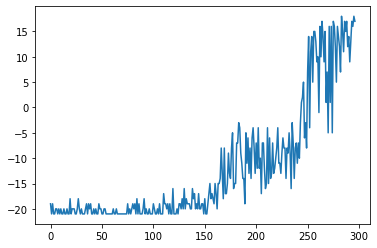

In [7]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-5:]) > 16.:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))